In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
PATH = '/content/drive/MyDrive/AI_Contest/SWAI/'

## 라이브러리 설치 및 설정

In [3]:
# !pip install catboost
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 조작 및 연산 도구
import pandas as pd
import numpy as np

# 주요 시각화 도구
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 데이터셋 분할, 정확도
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from statistics import mean

# 정규화 및 스케일링
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

# 머신러닝 도구
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# 실수 표현
pd.options.display.float_format = '{:.5f}'.format

## 데이터셋 로드 및 지정

In [10]:
train = pd.read_csv(PATH + 'DataSets/train.csv')
test = pd.read_csv(PATH + 'DataSets/test.csv')
submission = pd.read_csv(PATH + 'DataSets/submission.csv')

In [11]:
train.drop(['index'], axis=1, inplace=True)
test.drop(['index'], axis=1, inplace=True)

## EDA

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 69 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Q1            14959 non-null  float64
 1   Q2            14931 non-null  float64
 2   Q3            14950 non-null  float64
 3   Q4            14929 non-null  float64
 4   Q5            14962 non-null  float64
 5   Q6            14952 non-null  float64
 6   Q7            14924 non-null  float64
 7   Q8            14952 non-null  float64
 8   Q9            14944 non-null  float64
 9   Q10           14928 non-null  float64
 10  Q11           14941 non-null  float64
 11  Q12           14933 non-null  float64
 12  Q13           14960 non-null  float64
 13  Q14           14964 non-null  float64
 14  Q15           14955 non-null  float64
 15  Q16           14967 non-null  float64
 16  Q17           14963 non-null  float64
 17  Q18           14937 non-null  float64
 18  Q19           14947 non-nu

In [13]:
train['nerdiness'].astype(int).value_counts()

1    8303
0    6697
Name: nerdiness, dtype: int64

### 결측값 평균 대체

In [14]:
for col in train.columns:
    if train[col].isnull().values.any() == True:
        print(str(col))

Q1
Q2
Q3
Q4
Q5
Q6
Q7
Q8
Q9
Q10
Q11
Q12
Q13
Q14
Q15
Q16
Q17
Q18
Q19
Q20
Q21
Q22
Q23
Q24
Q25
Q26
country
TIPI1
TIPI2
TIPI3
TIPI4
TIPI5
TIPI6
TIPI7
TIPI8
TIPI9
TIPI10
education
gender
engnat
hand
religion
orientation
voted
married
familysize
ASD


In [15]:
q = [f'Q{i}' for i in range(1, 27)]
t = [f'TIPI{i}' for i in range(1, 11)]
cols = q+t+['education','gender','engnat','hand','religion','orientation',
        'voted','married','ASD', 'familysize']

In [16]:
for i in range(45):
  t_c_mean = train.loc[:, cols[i]].mean()
  train[cols[i]].fillna(t_c_mean, inplace=True)
  test[cols[i]].fillna(t_c_mean, inplace=True) 

In [17]:
f_mode = int(train['familysize'].mode(dropna=True))
train['familysize'].fillna(f_mode, inplace=True)
test['familysize'].fillna(f_mode, inplace=True)

In [18]:
for col in train.columns:
    if train[col].isnull().values.any() == True:
        print(str(col))

country


### 결측값 최빈값 대체

In [19]:
for col in train.columns:
    if train[col].isnull().values.any() == True:
        print(str(col))

country


In [20]:
q = [f'Q{i}' for i in range(1, 27)]
t = [f'TIPI{i}' for i in range(1, 11)]
cols = q+t+['education','gender','engnat','hand','religion','orientation',
        'voted','married','ASD', 'familysize']

In [21]:
for i in range(46):
  t_c_mode = int(train.loc[:, cols[i]].mode())
  train[cols[i]].fillna(t_c_mode, inplace=True)
  test[cols[i]].fillna(t_c_mode, inplace=True)  

In [22]:
for col in train.columns:
    if train[col].isnull().values.any() == True:
        print(str(col))

country


### 1. Q1 ~ Q26

"Q1" : "Never tell anyone the real reason you did something unless it is useful to do so.",

"Q2" : "The best way to handle people is to tell them what they want to hear.",

"Q3" : "One should take action only when sure it is morally right.",

"Q4" : "Most people are basically good and kind.",

"Q5" : "It is safest to assume that all people have a vicious streak and it will come out when they are given a chance.",

"Q6" : SECRET,

"Q7" : "There is no excuse for lying to someone else.",

"Q8" : "Generally speaking, people won't work hard unless they're forced to do so.",

"Q9" : "All in all, it is better to be humble and honest than to be important and dishonest.",

"Q10" : "When you ask someone to do something for you, it is best to give the real reasons for wanting it rather than giving reasons which carry more weight.",

"Q11" : "Most people who get ahead in the world lead clean, moral lives.",

"Q12" : "Anyone who completely trusts anyone else is asking for trouble.",

"Q13" : "The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught.",

"Q14" : SECRET,

"Q15" : "It is wise to flatter important people.",

"Q16" : "It is possible to be good in all respects.",

"Q17" : "P.T. Barnum was wrong when he said that there's a sucker born every minute.",

"Q18" : SECRET,

"Q19" : "People suffering from incurable diseases should have the choice of being put painlessly to death.",

"Q20" : "Most people forget more easily the death of their parents than the loss of their property."

"Q21 ~ 26" : SECRET

5에 가깝게 응답할 수록 nerdiness 비율이 높아지는 것을 알 수 있음 (질문의 내용 상)

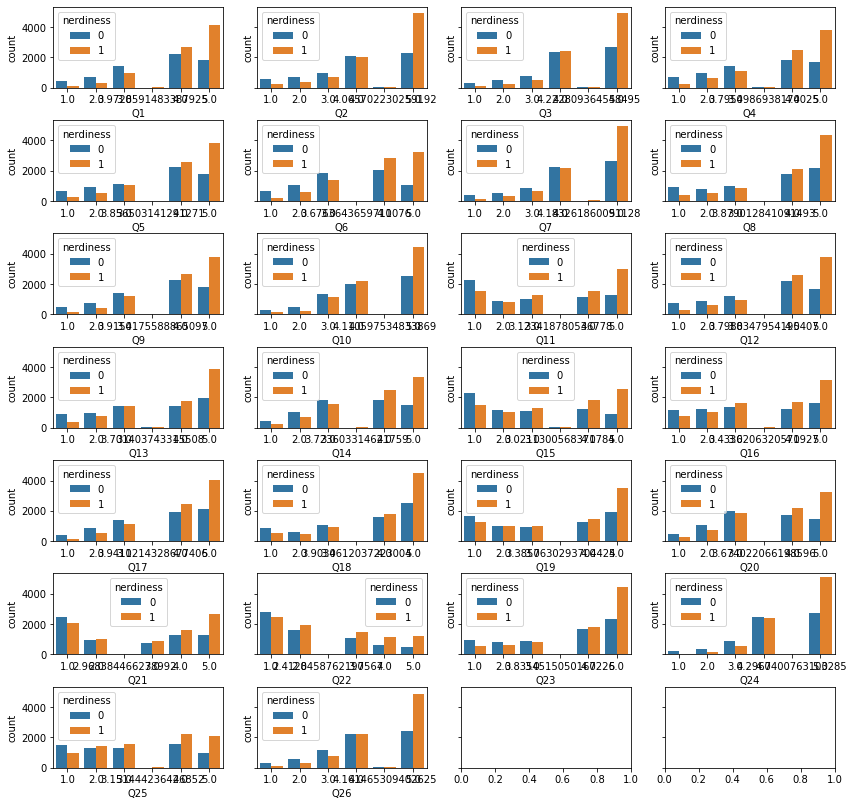

In [23]:
 fig, axes = plt.subplots(7,4, sharey=True, figsize=(14,14))
for i in range(7):
  for j in range(4):
    if i == 6 and j > 1: break
    sns.countplot(x=f'Q{(i*4)+(j+1)}',data=train, hue='nerdiness', ax=axes[i, j])
plt.subplots_adjust(wspace=0.2, hspace=0.4)

In [24]:
cols =  [f'Q{i}' for i in range(1, 27)]
train['que_score'] = train[cols].sum(axis=1) / 130
test['que_score'] = test[cols].sum(axis=1) / 130

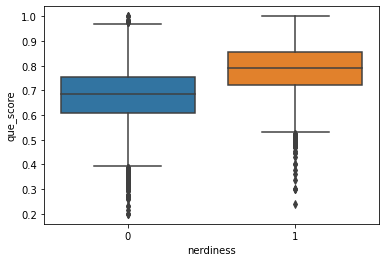

In [25]:
sns.boxplot(y = train['que_score'], x= train['nerdiness'])

### 2. Country

In [26]:
train['country'].unique()

array(['USA', 'NLD', 'ITA', 'ARE', 'DNK', 'GRC', 'QAT', 'GBR', 'ROU',
       'HUN', 'AUS', 'POL', 'CAN', 'ARG', 'FRA', 'DEU', 'UKR', 'BGR',
       'PAK', 'EST', 'PHL', 'SVN', nan, 'SRB', 'NZL', 'SWE', 'MAR', 'IDN',
       'HKG', 'LUX', 'CHE', 'MYS', 'RUS', 'BRA', 'NOR', 'PRT', 'MEX',
       'IND', 'VNM', 'AUT', 'FIN', 'ESP', 'GUM', 'CHL', 'SGP', 'HND',
       'KOR', 'COL', 'IRL', 'CYP', 'BEL', 'AZE', 'IRQ', 'SVK', 'TUR',
       'NGA', 'ZAF', 'JPN', 'ISR', 'URY', 'ISL', 'GHA', 'CZE', 'KEN',
       'ECU', 'EGY', 'JOR', 'CRI', 'THA', 'PER', 'NPL', 'SAU', 'MKD',
       'DOM', 'PRI', 'TTO', 'CUW', 'BGD', 'LTU', 'HRV', 'IRN', 'GRL',
       'SDN', 'KWT', 'LVA', 'ALB', 'MDV', 'CHN', 'VEN', 'MUS', 'JAM',
       'TWN', 'LBN', 'TUN', 'BIH', 'PNG', 'GUF', 'MDG', 'DZA', 'BRN',
       'ALA', 'VGB', 'SLV', 'OMN', 'PRY', 'LBY', 'GEO', 'BWA', 'FRO',
       'BHR', 'ZMB', 'UGA', 'NAM', 'KAZ', 'VIR', 'MLT', 'ARM', 'BHS',
       'MAC', 'KHM', 'MNP', 'SYR', 'MNG', 'MOZ', 'FJI', 'AFG', 'FSM',
       'AGO', '

In [27]:
train['country'].isnull().value_counts()

False    14810
True       190
Name: country, dtype: int64

In [28]:
test['country'].isnull().value_counts()

False    35002
True       450
Name: country, dtype: int64

In [29]:
# train data의 null values는 None으로 대체
train['country'].fillna('NONE', inplace=True)
train['country'].isnull().value_counts()

False    15000
Name: country, dtype: int64

In [30]:
test['country'].unique()

array(['CHL', 'USA', 'IDN', 'AUS', 'PHL', 'BRA', 'ITA', 'CAN', 'DEU',
       'GBR', 'ARG', 'GRC', 'POL', 'GRD', 'NOR', 'ROU', 'HKG', 'ARE',
       'FRA', 'NZL', 'MYS', 'HUN', 'FIN', 'SWE', 'DNK', 'MEX', 'NGA',
       'PAK', 'JPN', 'IND', 'PRT', nan, 'VEN', 'ESP', 'SRB', 'ZAF', 'CZE',
       'MNE', 'NLD', 'BRB', 'HRV', 'CHE', 'KOR', 'QAT', 'IRL', 'ISR',
       'NIC', 'AUT', 'CRI', 'PRY', 'AZE', 'BGR', 'URY', 'ALB', 'DZA',
       'THA', 'UKR', 'VIR', 'COL', 'EST', 'DOM', 'TUR', 'BEL', 'EGY',
       'SGP', 'CYP', 'JOR', 'VNM', 'BRN', 'RUS', 'MAR', 'ECU', 'SLE',
       'KWT', 'CUW', 'BIH', 'LVA', 'PRI', 'IRN', 'LKA', 'GHA', 'SAU',
       'TWN', 'KEN', 'LTU', 'SVN', 'NPL', 'TTO', 'ETH', 'GEO', 'MDA',
       'IRQ', 'SVK', 'PER', 'MLT', 'JAM', 'MUS', 'KAZ', 'MDG', 'HND',
       'RWA', 'BOL', 'LBN', 'BHS', 'GUM', 'PSE', 'TUN', 'LAO', 'SLV',
       'GUY', 'LUX', 'PNG', 'CHN', 'BGD', 'BLR', 'BHR', 'ISL', 'HTI',
       'SYR', 'MOZ', 'GTM', 'LBY', 'TZA', 'MWI', 'SDN', 'UGA', 'MKD',
       'JEY', '

In [31]:
test['country'].fillna('NONE', inplace=True)
test['country'].isnull().value_counts()

False    35452
Name: country, dtype: int64

In [32]:
country_not_in_train = []
for x in test['country'].unique():
    if x not in train['country'].unique():
        country_not_in_train.append(x)

In [33]:
len(country_not_in_train)

22

In [34]:
country_not_in_train

['GRD',
 'MNE',
 'NIC',
 'SLE',
 'LKA',
 'MDA',
 'BOL',
 'PSE',
 'HTI',
 'TZA',
 'JEY',
 'IMN',
 'CYM',
 'ZWE',
 'REU',
 'LCA',
 'SWZ',
 'VUT',
 'ATG',
 'BLZ',
 'MCO',
 'BFA']

In [35]:
country_index_in_train = []
for x in range(test.shape[0]):
    if test.loc[x, 'country']  in train['country'].unique():
        country_index_in_train.append(x)

In [36]:
len(country_index_in_train)

35394

In [37]:
test_in_train = test.loc[country_index_in_train, :]

In [38]:
country_index_not_in_train = []
for x in range(test.shape[0]):
    if test.loc[x, 'country']  not in train['country'].unique():
        country_index_not_in_train.append(x)

In [39]:
len(country_index_not_in_train)

58

In [40]:
test_not_in_train = test.loc[country_index_not_in_train, :]

In [41]:
test_not_in_train['country']

26       GRD
216      MNE
363      NIC
1128     SLE
1533     LKA
2269     MDA
2963     BOL
3273     PSE
4333     NIC
4708     HTI
5221     MDA
5330     MDA
6023     TZA
9253     JEY
9274     IMN
9634     CYM
9761     ZWE
10378    REU
11055    ZWE
12595    ZWE
12667    LCA
13503    IMN
13944    REU
13957    TZA
14887    LCA
15316    ZWE
15639    HTI
15690    SLE
16596    SWZ
16835    MDA
17593    PSE
18098    IMN
18573    SWZ
18756    IMN
18873    BOL
18946    VUT
20292    GRD
20498    SWZ
21261    ATG
21383    REU
21392    BLZ
22155    REU
22626    LKA
22770    JEY
22822    VUT
23733    MCO
24060    MCO
24408    LKA
25440    SWZ
25590    MNE
26529    ATG
28252    BFA
28735    LKA
29627    BFA
30564    CYM
33373    IMN
34795    BLZ
35135    IMN
Name: country, dtype: object

In [42]:
le = LabelEncoder()
country_encoded = le.fit_transform(train['country'])
train['country_encoded'] = country_encoded

In [43]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)
# 138개 국

{'AFG': 0, 'AGO': 1, 'ALA': 2, 'ALB': 3, 'ARE': 4, 'ARG': 5, 'ARM': 6, 'AUS': 7, 'AUT': 8, 'AZE': 9, 'BEL': 10, 'BGD': 11, 'BGR': 12, 'BHR': 13, 'BHS': 14, 'BIH': 15, 'BLR': 16, 'BRA': 17, 'BRB': 18, 'BRN': 19, 'BWA': 20, 'CAN': 21, 'CHE': 22, 'CHL': 23, 'CHN': 24, 'COL': 25, 'CRI': 26, 'CUW': 27, 'CYP': 28, 'CZE': 29, 'DEU': 30, 'DNK': 31, 'DOM': 32, 'DZA': 33, 'ECU': 34, 'EGY': 35, 'ESP': 36, 'EST': 37, 'ETH': 38, 'FIN': 39, 'FJI': 40, 'FRA': 41, 'FRO': 42, 'FSM': 43, 'GBR': 44, 'GEO': 45, 'GHA': 46, 'GRC': 47, 'GRL': 48, 'GTM': 49, 'GUF': 50, 'GUM': 51, 'GUY': 52, 'HKG': 53, 'HND': 54, 'HRV': 55, 'HUN': 56, 'IDN': 57, 'IND': 58, 'IRL': 59, 'IRN': 60, 'IRQ': 61, 'ISL': 62, 'ISR': 63, 'ITA': 64, 'JAM': 65, 'JOR': 66, 'JPN': 67, 'KAZ': 68, 'KEN': 69, 'KHM': 70, 'KOR': 71, 'KWT': 72, 'LAO': 73, 'LBN': 74, 'LBY': 75, 'LTU': 76, 'LUX': 77, 'LVA': 78, 'MAC': 79, 'MAR': 80, 'MDG': 81, 'MDV': 82, 'MEX': 83, 'MKD': 84, 'MLT': 85, 'MNG': 86, 'MNP': 87, 'MOZ': 88, 'MUS': 89, 'MWI': 90, 'MYS': 9

In [44]:
country_encoded_test = le.transform(test_in_train['country'])
test_in_train['country_encoded'] = country_encoded_test

In [45]:
le2 = LabelEncoder()
unique_country = le2.fit_transform(test_not_in_train['country'])
test_not_in_train['country_encoded'] = unique_country

In [46]:
test_not_in_train['country_encoded'].unique()

array([ 5, 13, 14, 17, 10, 12,  3, 15,  6, 19,  8,  7,  4, 21, 16,  9, 18,
       20,  0,  2, 11,  1])

In [47]:
test_not_in_train['country_encoded'] += 138

In [48]:
test_not_in_train['country_encoded'].unique()

array([143, 151, 152, 155, 148, 150, 141, 153, 144, 157, 146, 145, 142,
       159, 154, 147, 156, 158, 138, 140, 149, 139])

In [49]:
test_encoded = pd.concat([test_in_train, test_not_in_train])

In [50]:
test_encoded

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,age,hand,religion,orientation,voted,married,familysize,ASD,que_score,country_encoded
0,4.00000,4.00000,3.00000,5.00000,5.00000,5.00000,3.00000,5.00000,4.00000,5.00000,...,19,1.00000,4.00000,4.00000,1.00000,1.00000,3.00000,2.00000,0.83846,23
1,4.00000,5.00000,4.00000,4.00000,5.00000,4.00000,5.00000,5.00000,5.00000,4.00000,...,33,1.00000,1.00000,5.00000,2.00000,1.00000,5.00000,2.00000,0.86154,131
2,5.00000,5.00000,5.00000,5.00000,4.00000,5.00000,5.00000,5.00000,5.00000,4.00000,...,13,1.00000,4.00000,5.00000,2.00000,1.00000,3.00000,2.00000,0.83846,57
3,5.00000,4.00000,3.00000,4.00000,5.00000,4.00000,5.00000,4.00000,4.00000,5.00000,...,28,1.00000,2.00000,2.00000,2.00000,1.00000,3.00000,2.00000,0.75385,7
4,5.00000,5.00000,5.00000,5.00000,5.00000,3.00000,5.00000,5.00000,5.00000,5.00000,...,15,1.00000,4.00000,5.00000,2.00000,1.00000,2.00000,2.00000,0.81538,103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29627,2.00000,2.00000,4.00000,2.00000,4.00000,3.00000,4.00000,1.00000,2.00000,4.00000,...,20,1.00000,4.00000,1.00000,2.00000,1.00000,1.00000,2.00000,0.54615,139
30564,4.00000,5.00000,3.00000,4.00000,4.00000,4.00000,3.00000,4.00000,2.00000,4.00000,...,20,1.00000,4.00000,1.00000,2.00000,1.00000,2.00000,2.00000,0.70769,142
33373,1.00000,3.00000,5.00000,3.00000,4.00000,5.00000,5.00000,4.00000,3.00000,5.00000,...,30,1.00000,2.00000,2.00000,2.00000,1.00000,3.00000,2.00000,0.73077,145
34795,5.00000,5.00000,5.00000,5.00000,3.85650,5.00000,5.00000,5.00000,4.00000,5.00000,...,16,1.00000,1.00000,3.00000,2.00000,1.00000,4.00000,2.00000,0.90659,140


In [51]:
test=test_encoded.reindex(test.index)

\# 대륙 묶기

In [52]:
continent = pd.read_excel(PATH + 'DataPreprocessing/continent.xlsx')
continent

,country,A-2,A-3,continent,gni_per_person,IOC,FIFA
0,Aruba,AW,ABW,SA,27163.00000,ARU,ARU
1,Afghanistan,AF,AFG,AS,514.00000,AFG,AFG
2,Angola,AO,AGO,AF,3323.00000,ANG,ANG
3,Anguilla,AI,AIA,NA',NaN,AIA,AIA
4,Åland,AX,ALA,EU,NaN,ALD,NaN
...,...,...,...,...,...,...,...
244,Samoa,WS,WSM,NaN,NaN,SAM,SAM
245,Yemen,YE,YEM,NaN,NaN,YEM,YEM
246,South Africa,ZA,ZAF,AF,5127.00000,RSA,RSA
247,Zambia,ZM,ZMB,AF,1241.00000,ZAM,ZAM


In [53]:
continent = continent.iloc[:, 2:4]
continent

,A-3,continent
0,ABW,SA
1,AFG,AS
2,AGO,AF
3,AIA,NA'
4,ALA,EU
...,...,...
244,WSM,NaN
245,YEM,NaN
246,ZAF,AF
247,ZMB,AF


In [54]:
continent.dropna(inplace=True)

In [55]:
continent['continent'].unique() # 7

array(['SA', 'AS', 'AF', "NA'", 'EU', 'OC', 'AT'], dtype=object)

In [56]:
def replace_str(x):
  if x == "NA'":
    x = 'NA'
  else:
    x = x
  return x
continent['continent'] = continent['continent'].apply(replace_str)
continent[continent['continent']=="NA"]

,A-3,continent
3,AIA,NA
13,ATG,NA
27,BLM,NA
30,BMU,NA
39,CAN,NA
112,JAM,NA
128,LCA,NA
142,MEX,NA
164,NIC,NA
173,PAN,NA


In [57]:
train['continent'] = 0
test['continent'] = 0

In [58]:
for x in range(train.shape[0]):
  c_i = continent.index[continent['A-3']==train.loc[x, 'country']].tolist()
  if c_i:
    train.loc[x, 'continent'] = continent.loc[c_i[0], 'continent']
  else:
    train.loc[x, 'continent'] = 'NONE'

for x in range(test.shape[0]):
  c_i = continent.index[continent['A-3']==test.loc[x, 'country']].tolist()
  if c_i:
    test.loc[x, 'continent'] = continent.loc[c_i[0], 'continent']
  else:
    test.loc[x, 'continent'] = 'NONE'

In [59]:
train['continent'].value_counts()

NA      8530
EU      3889
AS      1164
OC       656
SA       444
NONE     200
AF       117
Name: continent, dtype: int64

In [60]:
test['continent'].value_counts()

NA      20342
EU       9045
AS       2684
OC       1492
SA       1082
NONE      478
AF        329
Name: continent, dtype: int64

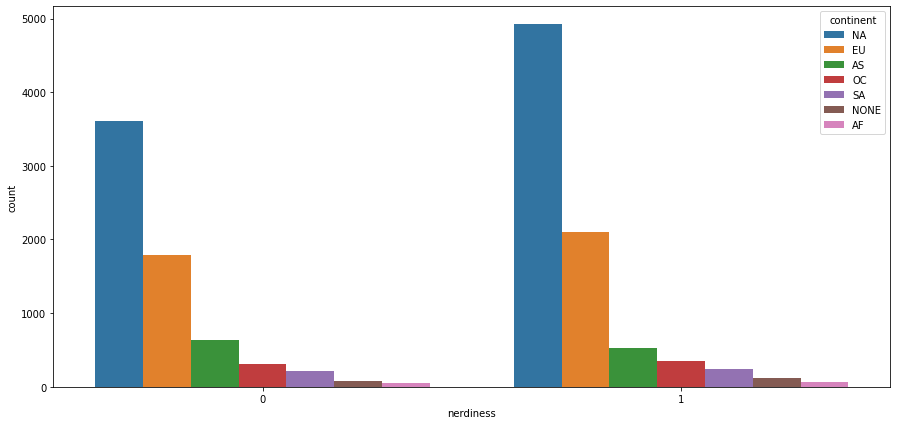

In [61]:
plt.figure(figsize = (15,7))
sns.countplot(x = train['nerdiness'], hue = train['continent'])

In [62]:
ohe_train = pd.get_dummies(train['continent'])
train = pd.concat([train, ohe_train], axis = 1)
train

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,que_score,country_encoded,continent,AF,AS,EU,NA,NONE,OC,SA
0,1.00000,5.00000,5.00000,5.00000,1.00000,4.00000,5.00000,5.00000,1.00000,3.00000,...,0.73077,131,NA,0,0,0,1,0,0,0
1,4.00000,4.00000,4.00000,4.00000,4.00000,5.00000,4.00000,4.00000,3.00000,3.00000,...,0.65385,131,NA,0,0,0,1,0,0,0
2,4.00000,5.00000,5.00000,4.00000,3.00000,5.00000,5.00000,5.00000,4.00000,4.00000,...,0.73846,94,EU,0,0,1,0,0,0,0
3,4.00000,4.00000,4.00000,2.00000,4.00000,3.00000,3.00000,5.00000,3.00000,4.00000,...,0.70000,131,NA,0,0,0,1,0,0,0
4,4.00000,4.00000,4.00000,4.00000,3.00000,3.00000,4.00000,2.00000,3.00000,4.00000,...,0.69231,64,EU,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,2.00000,5.00000,4.00000,3.00000,3.00000,4.00000,4.00000,4.00000,3.00000,4.00000,...,0.66923,131,NA,0,0,0,1,0,0,0
14996,5.00000,4.00000,5.00000,4.00000,4.00000,5.00000,5.00000,4.00000,4.00000,5.00000,...,0.80769,131,NA,0,0,0,1,0,0,0
14997,4.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,4.00000,5.00000,...,0.92308,131,NA,0,0,0,1,0,0,0
14998,5.00000,5.00000,4.00000,5.00000,5.00000,5.00000,5.00000,1.00000,5.00000,5.00000,...,0.82308,131,NA,0,0,0,1,0,0,0


In [63]:
ohe_test = pd.get_dummies(test['continent'])
test = pd.concat([test, ohe_test], axis = 1)
test

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,que_score,country_encoded,continent,AF,AS,EU,NA,NONE,OC,SA
0,4.00000,4.00000,3.00000,5.00000,5.00000,5.00000,3.00000,5.00000,4.00000,5.00000,...,0.83846,23,SA,0,0,0,0,0,0,1
1,4.00000,5.00000,4.00000,4.00000,5.00000,4.00000,5.00000,5.00000,5.00000,4.00000,...,0.86154,131,NA,0,0,0,1,0,0,0
2,5.00000,5.00000,5.00000,5.00000,4.00000,5.00000,5.00000,5.00000,5.00000,4.00000,...,0.83846,57,AS,0,1,0,0,0,0,0
3,5.00000,4.00000,3.00000,4.00000,5.00000,4.00000,5.00000,4.00000,4.00000,5.00000,...,0.75385,7,OC,0,0,0,0,0,1,0
4,5.00000,5.00000,5.00000,5.00000,5.00000,3.00000,5.00000,5.00000,5.00000,5.00000,...,0.81538,103,AS,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35447,4.00000,5.00000,5.00000,3.00000,3.00000,4.00000,5.00000,5.00000,4.00000,3.00000,...,0.83077,131,NA,0,0,0,1,0,0,0
35448,5.00000,5.00000,5.00000,5.00000,5.00000,4.00000,5.00000,3.00000,5.00000,3.00000,...,0.88462,44,EU,0,0,1,0,0,0,0
35449,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,5.00000,...,0.91538,131,NA,0,0,0,1,0,0,0
35450,5.00000,5.00000,4.00000,5.00000,5.00000,1.00000,5.00000,1.00000,5.00000,5.00000,...,0.80000,21,NA,0,0,0,1,0,0,0


### 3. Elapse

In [64]:
ela = ['introelapse', 'testelapse' ,'surveyelapse']

In [65]:
train['total_time_min'] = train[ela].sum(axis = 1) / 60

In [66]:
ela = ['introelapse', 'testelapse' ,'surveyelapse', 'total_time_min']
train.describe()[ela]
# 최대 시간이 250K minutes, i.e. 400 hours. 불가능
# 설문조사 평균 시간이 45분. 120분 이상은 대체 할 것임.

,introelapse,testelapse,surveyelapse,total_time_min
count,15000.00000,15000.00000,15000.00000,15000.00000
mean,767.13773,387.96567,2787.95853,65.71770
std,13835.94804,8513.03161,178595.45574,2990.11693
min,1.00000,1.00000,3.00000,1.55000
25%,4.00000,82.00000,126.00000,4.06667
50%,10.00000,106.00000,164.00000,5.35000
75%,36.00000,140.00000,217.00000,7.83333
max,855030.00000,474572.00000,15166994.00000,252811.48333


In [67]:
a = train[train['total_time_min'] <= 120]['total_time_min'].mean()
b = train[train['total_time_min'] <= 120]['introelapse'].mean()
c = train[train['total_time_min'] <= 120]['testelapse'].mean()
d = train[train['total_time_min'] <= 120]['surveyelapse'].mean()

wrong_time = []
for x in range(train.shape[0]):
    if train.loc[x, 'total_time_min'] > 120:
        train.loc[x, 'total_time_min'] = a
        train.loc[x, 'introelapse'] = b
        train.loc[x, 'testelapse'] = c
        train.loc[x, 'surveyelapse'] = d
        wrong_time.append(x)

In [68]:
train.describe()[ela]

,introelapse,testelapse,surveyelapse,total_time_min
count,15000.00000,15000.00000,15000.00000,15000.00000
mean,148.52367,139.96640,199.20599,8.12827
std,526.09313,206.63128,232.35234,10.34523
min,1.00000,1.00000,3.00000,1.55000
25%,4.00000,82.00000,126.00000,4.06667
50%,10.00000,106.00000,165.00000,5.35000
75%,37.00000,139.96640,214.00000,7.83333
max,7020.00000,6920.00000,6279.00000,119.20000


In [69]:
ela_test = ['introelapse', 'testelapse' ,'surveyelapse']
test['total_time_min'] = test[ela_test].sum(axis = 1) / 60

In [70]:
ela_test = ['introelapse', 'testelapse' ,'surveyelapse', 'total_time_min']
test.describe()[ela_test]

,introelapse,testelapse,surveyelapse,total_time_min
count,35452.00000,35452.00000,35452.00000,35452.00000
mean,876.76769,395.62493,2518.59348,63.18310
std,17389.50510,9645.58514,121509.14678,2066.93038
min,0.00000,1.00000,2.00000,1.35000
25%,4.00000,82.00000,126.75000,4.08333
50%,10.00000,105.00000,164.00000,5.35000
75%,38.00000,140.00000,216.00000,7.86667
max,1381016.00000,698533.00000,14555104.00000,242587.65000


In [71]:
a = test[test['total_time_min'] <= 120]['total_time_min'].mean()
b = test[test['total_time_min'] <= 120]['introelapse'].mean()
c = test[test['total_time_min'] <= 120]['testelapse'].mean()
d = test[test['total_time_min'] <= 120]['surveyelapse'].mean()

wrong_time = []
for x in range(test.shape[0]):
    if test.loc[x, 'total_time_min'] > 120:
        test.loc[x, 'total_time_min'] = a
        test.loc[x, 'introelapse'] = b
        test.loc[x, 'testelapse'] = c
        test.loc[x, 'surveyelapse'] = d
        wrong_time.append(x)

In [72]:
test.describe()[ela_test]

,introelapse,testelapse,surveyelapse,total_time_min
count,35452.00000,35452.00000,35452.00000,35452.00000
mean,154.35210,144.22894,196.87174,8.25755
std,522.04414,254.23633,204.50603,10.39832
min,0.00000,1.00000,2.00000,1.35000
25%,4.00000,82.00000,127.00000,4.08333
50%,10.00000,106.00000,164.00000,5.35000
75%,39.00000,142.00000,214.00000,7.86667
max,6942.00000,6978.00000,6622.00000,119.45000


In [73]:
cols = ['total_time_min', 'introelapse', 'surveyelapse', 'testelapse']

for col in cols:
    train[col] = np.log1p(train[col])
    test[col] = np.log1p(test[col])

### 4. TIPI1 ~ TIPI10

TIPI1	Extraverted, enthusiastic.

TIPI2	Critical, quarrelsome.

TIPI3	Dependable, self-disciplined.

TIPI4	Anxious, easily upset.

TIPI5	Open to new experiences, complex.

TIPI6	Reserved, quiet.

TIPI7	Sympathetic, warm.

TIPI8	Disorganized, careless.

TIPI9	Calm, emotionally stable.

TIPI10	Conventional, uncreative.

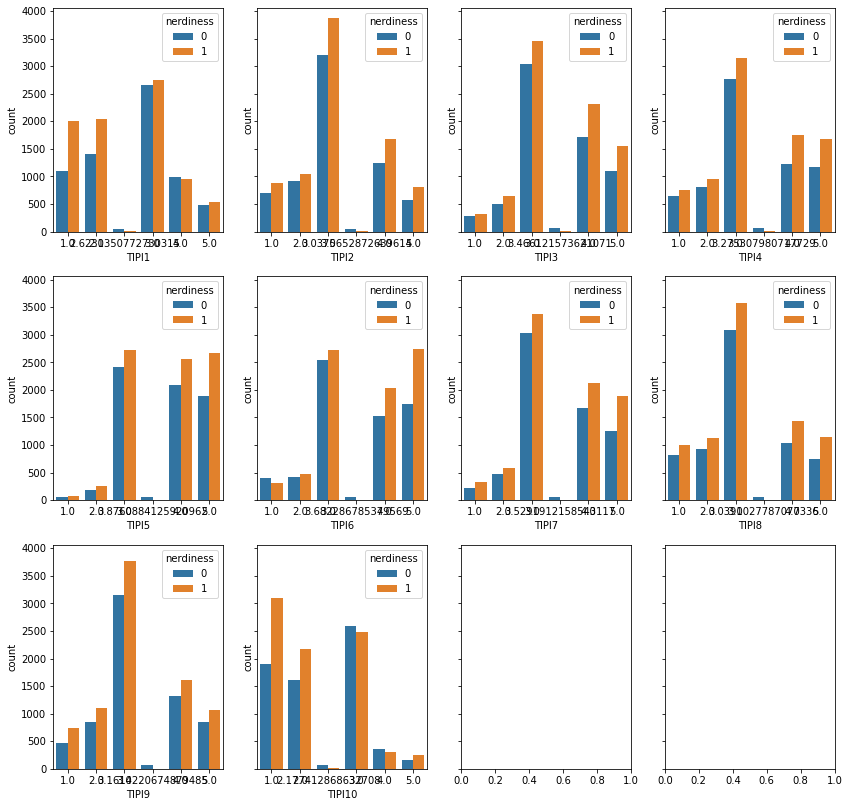

In [74]:
fig, axes = plt.subplots(3,4, sharey=True, figsize=(14,14))
for i in range(3):
  for j in range(4):
    if i == 2 and j > 1: break
    sns.countplot(x=f'TIPI{(i*4)+(j+1)}',data=train, hue='nerdiness', ax=axes[i, j])
plt.subplots_adjust(wspace=0.2, hspace=0.2)

In [75]:
tipi_cols = [f'TIPI{i}' for i in range(1, 11)]

train['tipi_score'] = train[tipi_cols].sum(axis = 1)
test['tipi_score'] = test[tipi_cols].sum(axis=1)

In [76]:
train.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,continent,AF,AS,EU,NA,NONE,OC,SA,total_time_min,tipi_score
0,1.00000,5.00000,5.00000,5.00000,1.00000,4.00000,5.00000,5.00000,1.00000,3.00000,...,NA,0,0,0,1,0,0,0,2.33860,37.00000
1,4.00000,4.00000,4.00000,4.00000,4.00000,5.00000,4.00000,4.00000,3.00000,3.00000,...,NA,0,0,0,1,0,0,0,1.50408,29.00000
2,4.00000,5.00000,5.00000,4.00000,3.00000,5.00000,5.00000,5.00000,4.00000,4.00000,...,EU,0,0,1,0,0,0,0,1.52967,31.00000
3,4.00000,4.00000,4.00000,2.00000,4.00000,3.00000,3.00000,5.00000,3.00000,4.00000,...,NA,0,0,0,1,0,0,0,1.68021,35.00000
4,4.00000,4.00000,4.00000,4.00000,3.00000,3.00000,4.00000,2.00000,3.00000,4.00000,...,EU,0,0,1,0,0,0,0,2.72894,34.00000


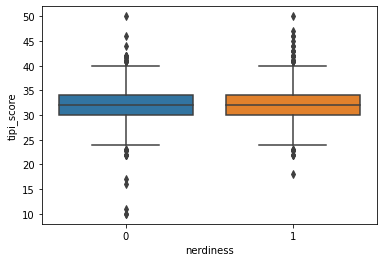

In [77]:
# 예측에 도움 X
sns.boxplot( y = train['tipi_score'], x = train['nerdiness'])

### 5. VCL1 ~ VCL16

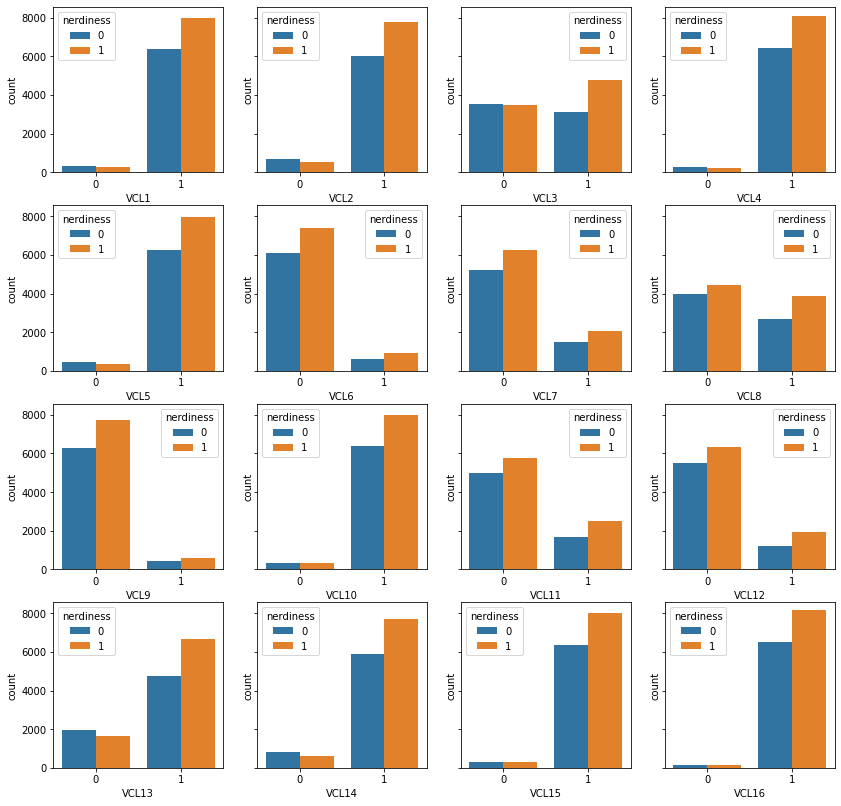

In [78]:
fig, axes = plt.subplots(4,4, sharey=True, figsize=(14,14))
for i in range(4):
  for j in range(4):
    sns.countplot(x=f'VCL{(i*4)+(j+1)}',data=train, hue='nerdiness', ax=axes[i, j])
plt.subplots_adjust(wspace=0.2, hspace=0.2)

### 6. Education

"How much education have you completed?"

1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree

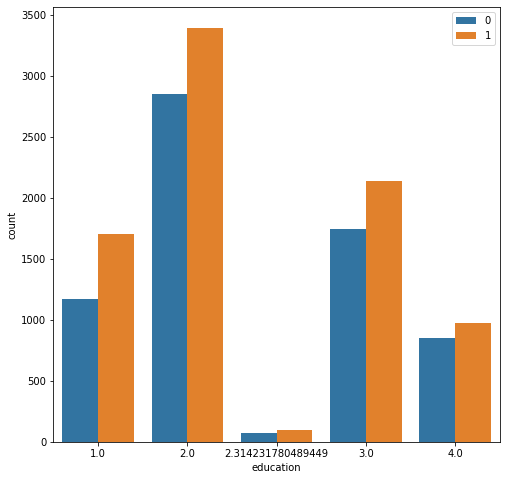

In [79]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='education',data=train, hue='nerdiness')
ax.legend(loc='best')

### 7. Urban

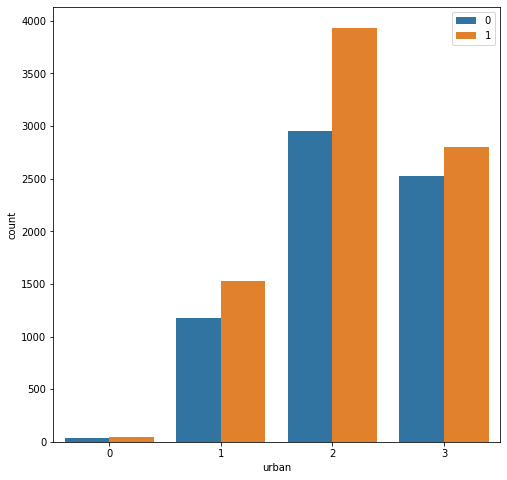

In [80]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='urban',data=train, hue='nerdiness')
ax.legend(loc='best')

### 8. Gender

[Text(0, 0, '1'), Text(0, 0, '2'), Text(0, 0, '3')]

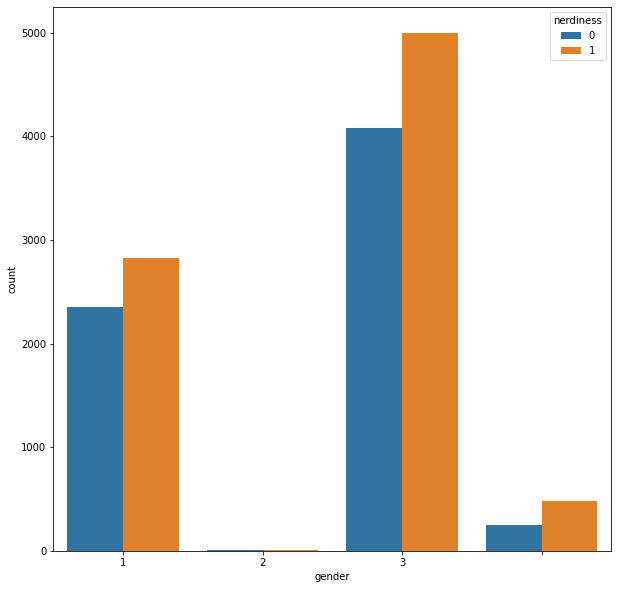

In [81]:
plt.figure(figsize=(10,10))
ax = sns.countplot(x='gender',data=train, hue='nerdiness')
ax.set_xticklabels(['1','2','3'])

### 9. Engnat

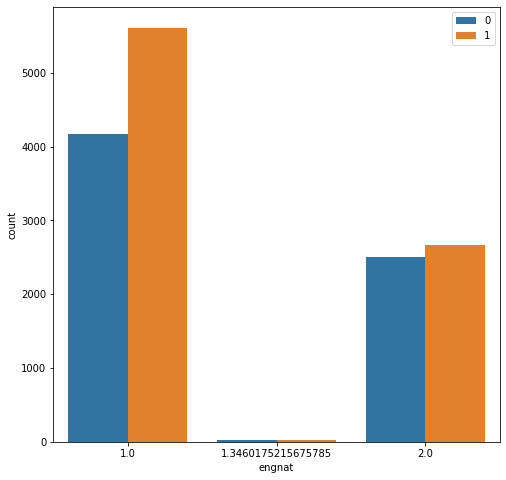

In [82]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='engnat',data=train, hue='nerdiness')
ax.legend(loc='best')

### 10. Age

In [83]:
train['age'].value_counts()

18     1386
17     1313
16     1239
19     1101
20      932
       ... 
77        1
99        1
81        1
336       1
80        1
Name: age, Length: 76, dtype: int64

In [84]:
train['age'].unique()

array([   20,    49,    43,    17,    18,    26,    40,    34,    29,
          24,    13,    14,    16,    19,    15,    23,    32,    22,
          25,    27,    33,    41,    21,    50,    64,    44,    31,
          35,    67,    48,    38,    46,    58,    59,    52,    42,
          37,    55,    36,    45,    28,    47,    30,    39,    54,
          53,    69,    57,    72,    51,    56,    65,    60,    61,
         100,    66,    73,    70,    68,   123,    62,    71,    78,
          76,    63,   545,    74,    88,   722, 38822,    75,    77,
          99,    81,   336,    80])

In [85]:
train[(train['age']==123) | (train['age']==545) | (train['age']==722) | (train['age']==38822) | (train['age']==336)]

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,continent,AF,AS,EU,NA,NONE,OC,SA,total_time_min,tipi_score
1739,4.00000,4.00000,5.00000,5.00000,5.00000,4.00000,5.00000,5.00000,5.00000,4.00000,...,NA,0,0,0,1,0,0,0,1.43111,36.00000
4002,4.00000,4.00000,5.00000,5.00000,5.00000,4.00000,5.00000,5.00000,5.00000,4.00000,...,NA,0,0,0,1,0,0,0,1.43111,36.00000
4976,4.00000,5.00000,4.00000,3.00000,4.00000,4.00000,4.00000,4.00000,5.00000,5.00000,...,EU,0,0,1,0,0,0,0,1.86408,29.00000
6725,1.00000,1.00000,3.00000,3.00000,5.00000,3.00000,5.00000,1.00000,5.00000,1.00000,...,NA,0,0,0,1,0,0,0,2.21138,29.00000
9273,5.00000,3.00000,1.00000,5.00000,4.00000,3.00000,3.00000,4.00000,5.00000,1.00000,...,NA,0,0,0,1,0,0,0,1.52243,29.00000
14135,4.00000,5.00000,4.00000,4.00000,5.00000,5.00000,5.00000,4.00000,4.00000,5.00000,...,AF,1,0,0,0,0,0,0,1.93634,34.00000


In [86]:
que_cols =  ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10',
       'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20',
       'Q21', 'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'education', 'voted','married']
cols = ['education', 'voted','married', 'urban', 'familysize', 'country']

In [87]:
train[train['age'] == 38822][cols]
# 고졸 이하, 투표X, 미혼 => 알 수 없음 => 38

,education,voted,married,urban,familysize,country
9273,1.00000,2.00000,1.00000,2,3.00000,USA


In [88]:
train.loc[9273, 'age'] = 38

In [89]:
train[train['age'] == 123][cols]
# 고졸, 투표X, 미혼 => 12, 23 중에 23이 타당

,education,voted,married,urban,familysize,country
1739,2.00000,2.00000,1.00000,3,3.00000,CAN
4002,2.00000,2.00000,1.00000,3,3.00000,CAN


In [90]:
train.loc[1739, 'age'] = 23
train.loc[4002, 'age'] = 23

In [91]:
train[train['age'] == 722][cols]
# 학사, 투표O, 기혼 => 72, 22 중에 72가 타당

,education,voted,married,urban,familysize,country
6725,3.00000,1.00000,2.00000,2,3.00000,USA


In [92]:
train.loc[6725, 'age'] = 72

In [93]:
train[train['age'] == 336][cols]
# 학사, 투표O, 미혼 => 알 수 없음 => 36

,education,voted,married,urban,familysize,country
14135,3.00000,1.00000,1.00000,1,2.00000,BWA


In [94]:
train.loc[14135, 'age'] = 36

In [95]:
train[train['age'] == 545][cols]
# 고졸, 투표O, 기혼 => 알 수 없음 => 54

,education,voted,married,urban,familysize,country
4976,2.00000,1.00000,2.00000,1,4.00000,NOR


In [96]:
train.loc[4976, 'age'] = 54

In [97]:
test['age'].unique()
# 1997, 1999는 년도를 잘못 기입할 가능성

array([   19,    33,    13,    28,    15,    22,    26,    25,    16,
          20,    21,    24,    53,    46,    34,    27,    40,    23,
          31,    17,    18,    37,    39,    14,    49,    42,    47,
          50,    29,    30,    38,    54,    71,    52,    43,    35,
          32,    56,    45,    36,    62,    70,    41,    48,    58,
          44,    57,    51,    64,    75,    76,    65,    61,    55,
          63,    60,    66,    69,    82,   116,    59,   374,    73,
          74,    67, 38822,    99,    72,    83,    68,   809,    77,
        1997,    79,   100,   545,    78,    88,   155,    81,    90,
        1999,   336,    80,   722])

In [98]:
test[test['age'] == 1997][cols]
# 

,education,voted,married,urban,familysize,country
8625,2.00000,2.00000,1.00000,2,3.00000,MYS
26332,2.00000,2.00000,1.00000,2,3.00000,MYS


In [99]:
test.loc[8625, 'age'] = 18
test.loc[26332, 'age'] = 18

In [100]:
test[test['age'] == 1999][cols]

,education,voted,married,urban,familysize,country
17311,2.00000,2.00000,1.00000,3,5.00000,MYS
33787,2.00000,2.00000,1.00000,3,5.00000,MYS


In [101]:
test.loc[17311, 'age'] = 18
test.loc[33787, 'age'] = 18

In [102]:
test[test['age'] == 38822][cols]

,education,voted,married,urban,familysize,country
4609,1.00000,2.00000,1.00000,2,3.00000,USA


In [103]:
test.loc[4609, 'age'] = 38

In [104]:
test[test['age'] == 545][cols]

,education,voted,married,urban,familysize,country
11922,2.00000,1.00000,2.00000,1,4.00000,NOR


In [105]:
test.loc[11922, 'age'] = 54

In [106]:
test[test['age'] == 116][cols]
# 고졸, 투표X, 미혼 =>16

,education,voted,married,urban,familysize,country
2578,2.00000,2.00000,1.00000,3,2.00000,USA
26070,2.00000,2.00000,1.00000,3,2.00000,USA


In [107]:
test.loc[2578, 'age'] = 16
test.loc[26070, 'age'] = 16

In [108]:
test[test['age'] == 374][cols]
# 학사, 투표X, 기혼 => 파악 X => 37, 74 최빈값 대체 => 37

,education,voted,married,urban,familysize,country
2802,3.00000,2.00000,2.00000,3,3.00000,BRA
24301,3.00000,2.00000,2.00000,3,3.00000,BRA


In [109]:
test.loc[2802, 'age'] = 37
test.loc[24301, 'age'] = 37

In [110]:
test[test['age'] == 809][cols]
# 석사, 투표X, 미혼 => 80

,education,voted,married,urban,familysize,country
8190,4.00000,2.00000,1.00000,2,1.00000,GBR
30699,4.00000,2.00000,1.00000,2,1.00000,GBR


In [111]:
test.loc[8190, 'age'] = 80
test.loc[30699, 'age'] = 80

In [112]:
test[test['age'] == 722][cols]
# 학사, 투표O, 기혼 => 72

,education,voted,married,urban,familysize,country
33783,3.00000,1.00000,2.00000,2,3.00000,USA


In [113]:
test.loc[33783, 'age'] = 72

In [114]:
test[test['age'] == 336][cols]
# 학사, 투표O, 미혼 => 파악X => 36

,education,voted,married,urban,familysize,country
28448,3.00000,1.00000,1.00000,1,2.00000,BWA


In [115]:
test.loc[28448, 'age'] = 36

In [116]:
test[test['age'] == 155][cols]
# 고등, 투표X, 미혼 => 15 

,education,voted,married,urban,familysize,country
13943,2.00000,2.00000,1.00000,3,2.00000,IDN
34046,2.00000,2.00000,1.00000,3,2.00000,IDN


In [117]:
test.loc[13943, 'age'] = 15
test.loc[34046, 'age'] = 15

In [118]:
test['age'].unique()

array([ 19,  33,  13,  28,  15,  22,  26,  25,  16,  20,  21,  24,  53,
        46,  34,  27,  40,  23,  31,  17,  18,  37,  39,  14,  49,  42,
        47,  50,  29,  30,  38,  54,  71,  52,  43,  35,  32,  56,  45,
        36,  62,  70,  41,  48,  58,  44,  57,  51,  64,  75,  76,  65,
        61,  55,  63,  60,  66,  69,  82,  59,  73,  74,  67,  99,  72,
        83,  68,  80,  77,  79, 100,  78,  88,  81,  90])

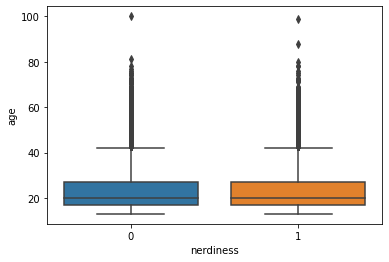

In [119]:
sns.boxplot(x=train['nerdiness'], y=train['age'])
# 예측에 도움 X

### 11. Hand

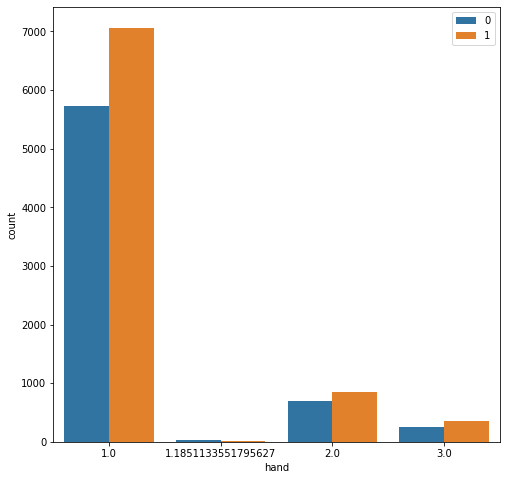

In [120]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='hand',data=train, hue='nerdiness')
ax.legend(loc='best')

### 12. Religion

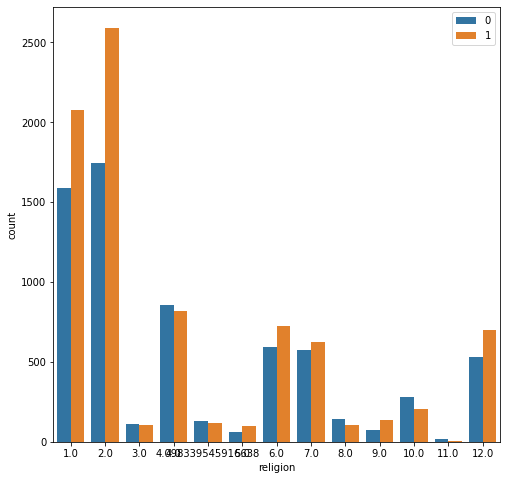

In [121]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='religion',data=train, hue='nerdiness')
ax.legend(loc='best')

### 13. Orientation

"What is your sexual orientation?"

1=Heterosexual, 2=Bisexual, 3=Homosexual, 4=Asexual, 5=Other

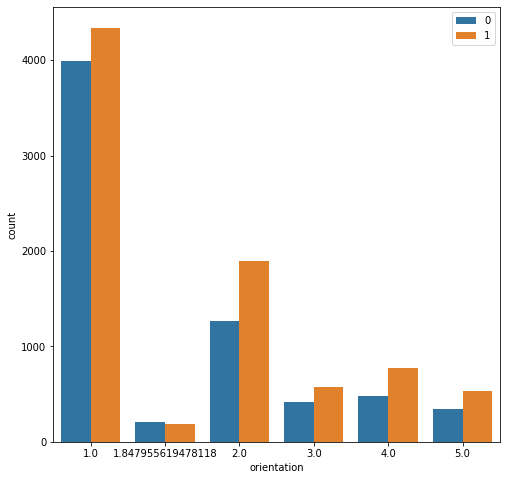

In [122]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='orientation',data=train, hue='nerdiness')
ax.legend(loc='best')

### 14. Voted

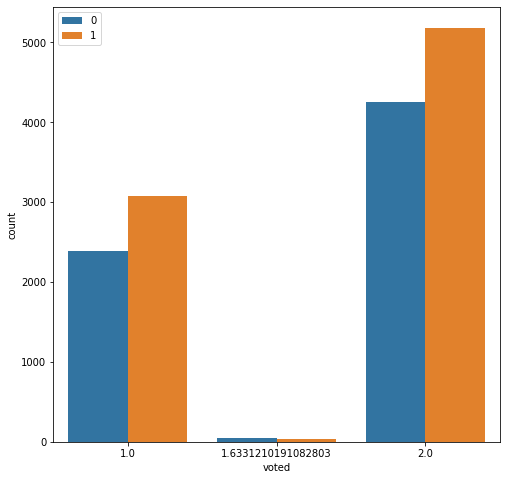

In [123]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='voted',data=train, hue='nerdiness')
ax.legend(loc='best')

### 15. Married

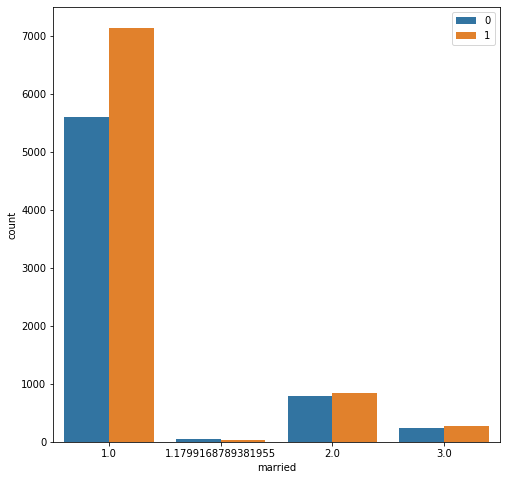

In [124]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='married',data=train, hue='nerdiness')
ax.legend(loc='best')

### 16. Familysize
32 이상 =>

0.7813333333333333
0.7826138130951644


In [125]:
train['familysize'].value_counts()

2.00000       6622
3.00000       3573
1.00000       2373
4.00000       1445
5.00000        535
6.00000        256
7.00000         97
8.00000         53
9.00000         14
10.00000        10
13.00000         5
11.00000         4
12.00000         3
39.00000         2
23.00000         2
14.00000         2
16.00000         1
2919.00000       1
19.00000         1
17.00000         1
Name: familysize, dtype: int64

In [126]:
train[train['familysize'] > 32]['age']

1019    100
1287     15
9817     15
Name: age, dtype: int64

In [127]:
train.loc[1019, 'familysize'] = 2
train.loc[1287, 'familysize'] = 2
train.loc[9817, 'familysize'] = 2

In [128]:
test['familysize'].value_counts()

2.00000           15670
3.00000            8467
1.00000            5679
4.00000            3371
5.00000            1255
6.00000             524
7.00000             227
8.00000             109
9.00000              58
10.00000             32
11.00000             20
13.00000             11
12.00000              9
16.00000              3
23.00000              2
39947739.00000        2
47.00000              2
22.00000              2
36.00000              2
14.00000              2
15.00000              2
2919.00000            1
19.00000              1
17.00000              1
Name: familysize, dtype: int64

In [129]:
test[test['familysize'] > 32]['familysize']

4665    39947739.00000
5125          47.00000
6475          47.00000
10075         36.00000
11773       2919.00000
25389   39947739.00000
30771         36.00000
Name: familysize, dtype: float64

In [130]:
test.loc[4665, 'familysize'] = 2
test.loc[5125, 'familysize'] = 2
test.loc[6425, 'familysize'] = 2
test.loc[10075, 'familysize'] = 2
test.loc[11773, 'familysize'] = 2
test.loc[25389, 'familysize'] = 2
test.loc[30771, 'familysize'] = 2

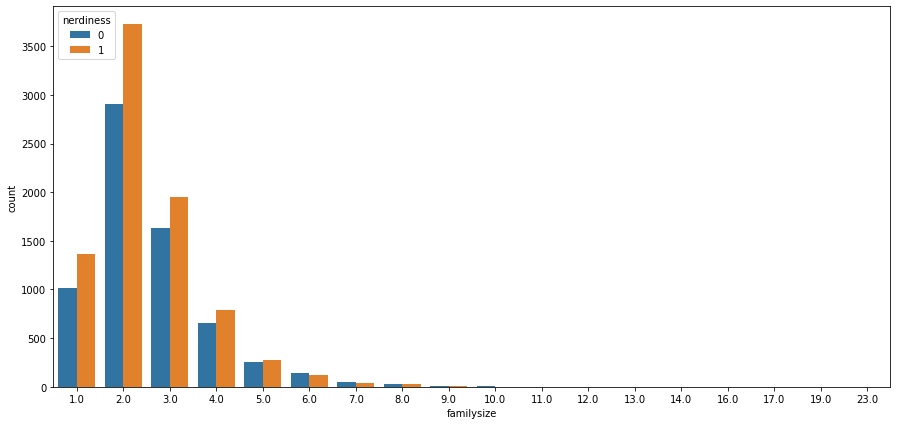

In [131]:
plt.figure(figsize = (15,7))
sns.countplot(hue = train['nerdiness'], x= train['familysize'])

### 16.1 FamilySize
10이상 =>

In [132]:
train['familysize'].value_counts()

2.00000     6625
3.00000     3573
1.00000     2373
4.00000     1445
5.00000      535
6.00000      256
7.00000       97
8.00000       53
9.00000       14
10.00000      10
13.00000       5
11.00000       4
12.00000       3
23.00000       2
14.00000       2
19.00000       1
16.00000       1
17.00000       1
Name: familysize, dtype: int64

In [133]:
train[train['familysize'] > 10]['age']

474      23
655      30
2935     20
4219     24
4696     26
5160     24
5646     13
6050     42
6061     65
6305     28
6603     32
8201     17
8552     50
10551    55
11006    20
11274    23
11889    16
13231    25
14918    30
Name: age, dtype: int64

In [134]:
train.loc[474, 'familysize'] = 2
train.loc[655, 'familysize'] = 2
train.loc[1019, 'familysize'] = 2
train.loc[1287, 'familysize'] = 2
train.loc[2935, 'familysize'] = 2
train.loc[4219, 'familysize'] = 2
train.loc[4696, 'familysize'] = 2
train.loc[5160, 'familysize'] = 2
train.loc[5646, 'familysize'] = 2
train.loc[6050, 'familysize'] = 2
train.loc[6061, 'familysize'] = 2
train.loc[6305, 'familysize'] = 2
train.loc[6603, 'familysize'] = 2
train.loc[8201, 'familysize'] = 2
train.loc[8552, 'familysize'] = 2
train.loc[9817, 'familysize'] = 2
train.loc[10551, 'familysize'] = 2
train.loc[11006, 'familysize'] = 2
train.loc[11274, 'familysize'] = 2
train.loc[11889, 'familysize'] = 2
train.loc[13231, 'familysize'] = 2
train.loc[14918, 'familysize'] = 2

In [135]:
test['familysize'].value_counts()

2.00000     15676
3.00000      8467
1.00000      5679
4.00000      3371
5.00000      1255
6.00000       524
7.00000       227
8.00000       109
9.00000        58
10.00000       32
11.00000       20
13.00000       11
12.00000        9
16.00000        3
15.00000        2
14.00000        2
23.00000        2
22.00000        2
47.00000        1
19.00000        1
17.00000        1
Name: familysize, dtype: int64

In [136]:
test[test['familysize'] > 10]['familysize']

924     11.00000
1486    23.00000
1739    11.00000
3220    13.00000
3255    11.00000
4031    11.00000
5161    13.00000
6475    47.00000
7610    13.00000
8209    22.00000
8668    16.00000
8726    22.00000
11103   16.00000
12436   11.00000
12681   11.00000
12750   11.00000
13243   13.00000
13247   12.00000
13398   16.00000
14287   12.00000
14526   23.00000
14988   11.00000
15466   13.00000
15567   13.00000
16826   14.00000
18326   12.00000
18382   15.00000
18809   11.00000
20165   11.00000
20699   12.00000
21608   13.00000
21831   12.00000
22410   11.00000
23541   12.00000
23859   19.00000
24505   12.00000
24507   17.00000
24578   11.00000
24980   11.00000
25933   15.00000
26719   13.00000
26723   13.00000
27496   11.00000
28141   12.00000
28366   11.00000
28628   11.00000
29557   11.00000
29901   12.00000
30845   11.00000
31515   11.00000
32194   13.00000
34357   13.00000
34847   14.00000
35095   11.00000
Name: familysize, dtype: float64

In [137]:
test.loc[924, 'familysize'] = 2
test.loc[1486, 'familysize'] = 2
test.loc[1739, 'familysize'] = 2
test.loc[3220, 'familysize'] = 2
test.loc[3255, 'familysize'] = 2
test.loc[4031, 'familysize'] = 2
test.loc[4665, 'familysize'] = 2
test.loc[5125, 'familysize'] = 2
test.loc[5161, 'familysize'] = 2
test.loc[6475, 'familysize'] = 2
test.loc[7610, 'familysize'] = 2
test.loc[8209, 'familysize'] = 2
test.loc[8668, 'familysize'] = 2
test.loc[8726, 'familysize'] = 2
test.loc[10075, 'familysize'] = 2
test.loc[11103, 'familysize'] = 2
test.loc[11773, 'familysize'] = 2
test.loc[12436, 'familysize'] = 2
test.loc[12681, 'familysize'] = 2
test.loc[12750, 'familysize'] = 2
test.loc[13243, 'familysize'] = 2
test.loc[13247, 'familysize'] = 2
test.loc[13398, 'familysize'] = 2
test.loc[14287, 'familysize'] = 2
test.loc[14526, 'familysize'] = 2
test.loc[14988, 'familysize'] = 2
test.loc[15466, 'familysize'] = 2
test.loc[15567, 'familysize'] = 2
test.loc[16826, 'familysize'] = 2
test.loc[18326, 'familysize'] = 2
test.loc[18382, 'familysize'] = 2
test.loc[18809, 'familysize'] = 2
test.loc[20165, 'familysize'] = 2
test.loc[20699, 'familysize'] = 2
test.loc[21608, 'familysize'] = 2
test.loc[21831, 'familysize'] = 2
test.loc[22410, 'familysize'] = 2
test.loc[23541, 'familysize'] = 2
test.loc[23859, 'familysize'] = 2
test.loc[24505, 'familysize'] = 2
test.loc[24507, 'familysize'] = 2
test.loc[24578, 'familysize'] = 2
test.loc[24980, 'familysize'] = 2
test.loc[25389, 'familysize'] = 2
test.loc[25933, 'familysize'] = 2
test.loc[26719, 'familysize'] = 2
test.loc[26723, 'familysize'] = 2
test.loc[27496, 'familysize'] = 2
test.loc[28141, 'familysize'] = 2
test.loc[28366, 'familysize'] = 2
test.loc[28628, 'familysize'] = 2
test.loc[29557, 'familysize'] = 2
test.loc[29901, 'familysize'] = 2
test.loc[30771, 'familysize'] = 2
test.loc[30845, 'familysize'] = 2
test.loc[31515, 'familysize'] = 2
test.loc[32194, 'familysize'] = 2
test.loc[34357, 'familysize'] = 2
test.loc[34847, 'familysize'] = 2
test.loc[35095, 'familysize'] = 2

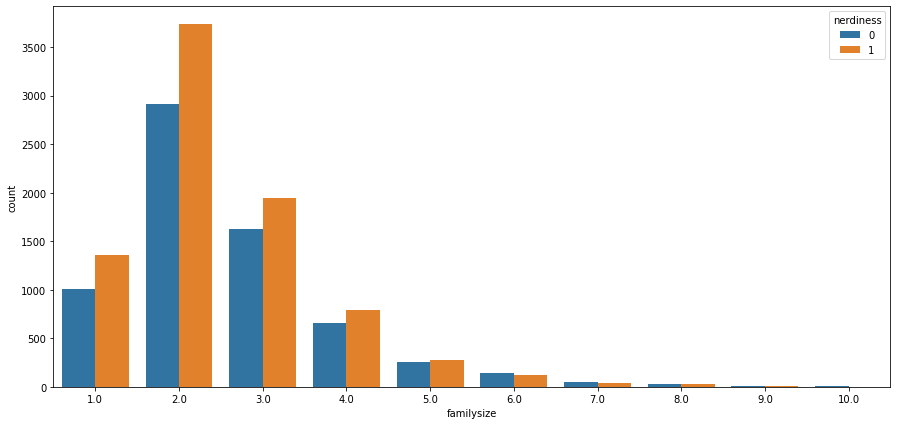

In [138]:
plt.figure(figsize = (15,7))
sns.countplot(hue = train['nerdiness'], x= train['familysize'])

### 17. ASD

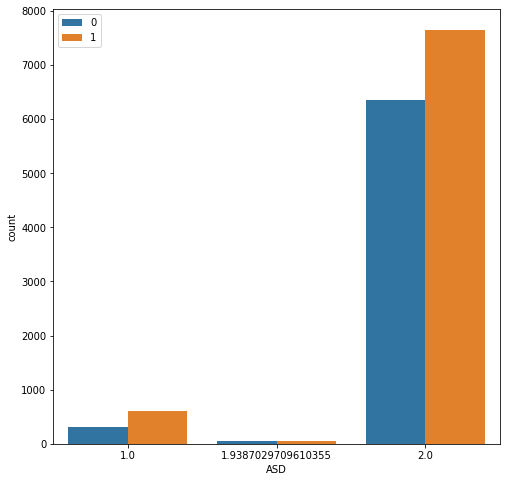

In [139]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='ASD',data=train, hue='nerdiness')
ax.legend(loc='best')

## Plot

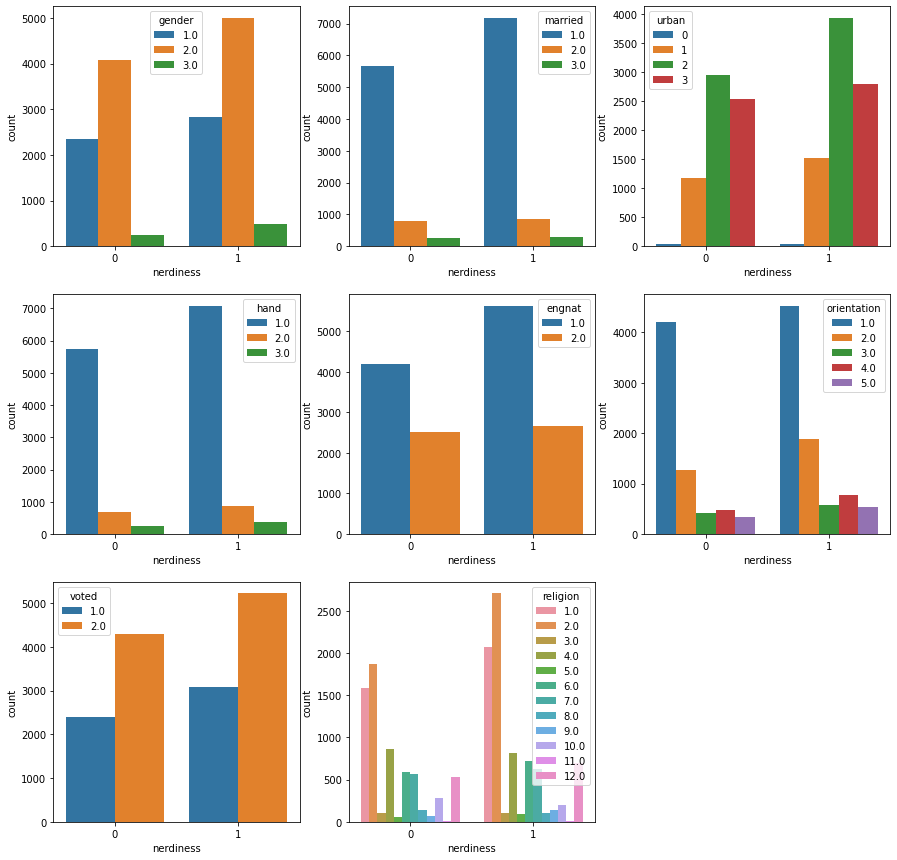

In [ ]:
plt.figure(figsize = (15,15))

plt.subplot(3,3,1)
sns.countplot(x = train['nerdiness'], hue = train['gender'])

plt.subplot(3,3,2)
sns.countplot(x = train['nerdiness'], hue = train['married'])

plt.subplot(3,3,3)
sns.countplot(x = train['nerdiness'], hue = train['urban'])

plt.subplot(3,3,4)
sns.countplot(x = train['nerdiness'], hue = train['hand'])

plt.subplot(3,3,5)
sns.countplot(x = train['nerdiness'], hue = train['engnat'])

plt.subplot(3,3,6)
sns.countplot(x = train['nerdiness'], hue = train['orientation'])

plt.subplot(3,3,7)
sns.countplot(x = train['nerdiness'], hue = train['voted'])

plt.subplot(3,3,8)
sns.countplot(x = train['nerdiness'], hue = train['religion'])

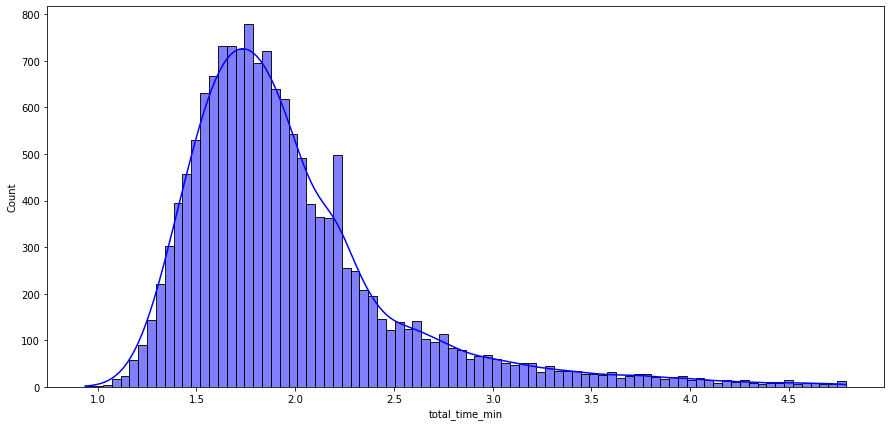

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(x = train['total_time_min'], kde=True, color='blue')

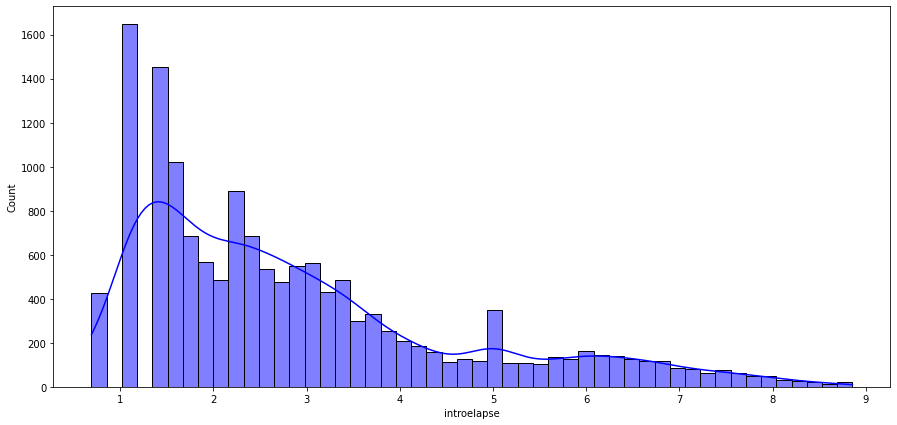

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(x = train['introelapse'], kde=True, color='blue')

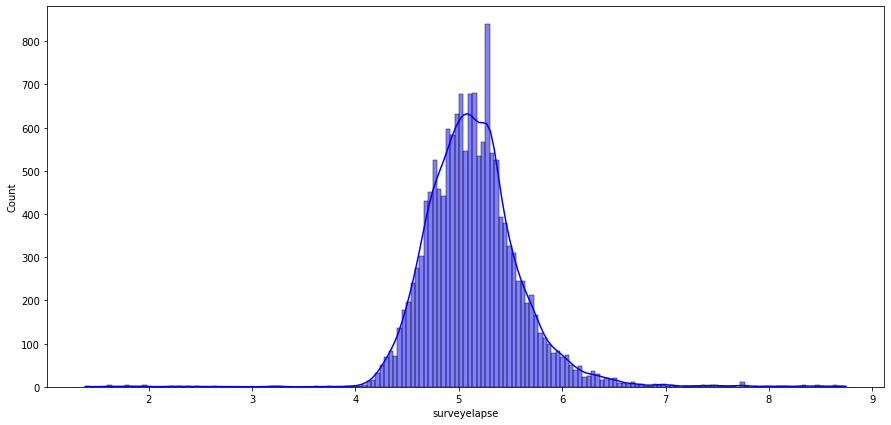

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(x = train['surveyelapse'], kde=True, color='blue')

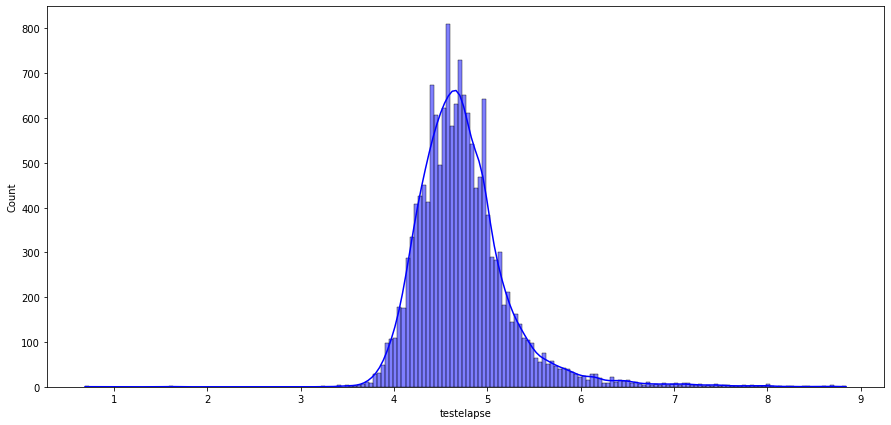

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(x = train['testelapse'], kde=True, color='blue')

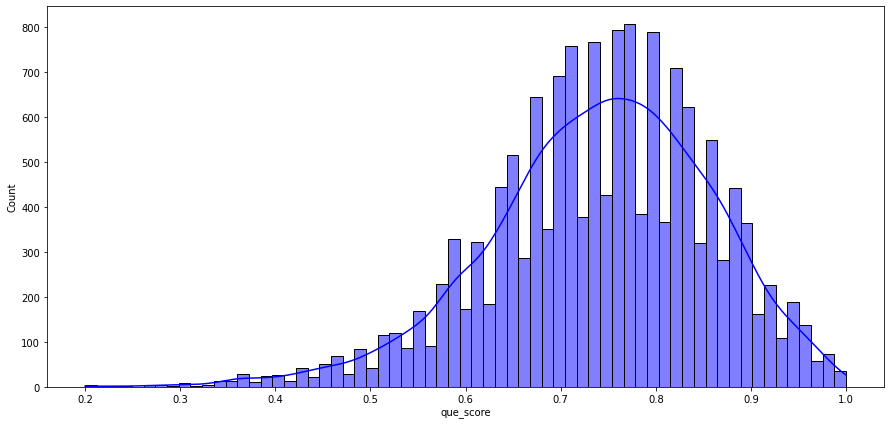

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(x = train['que_score'], kde=True, color='blue')

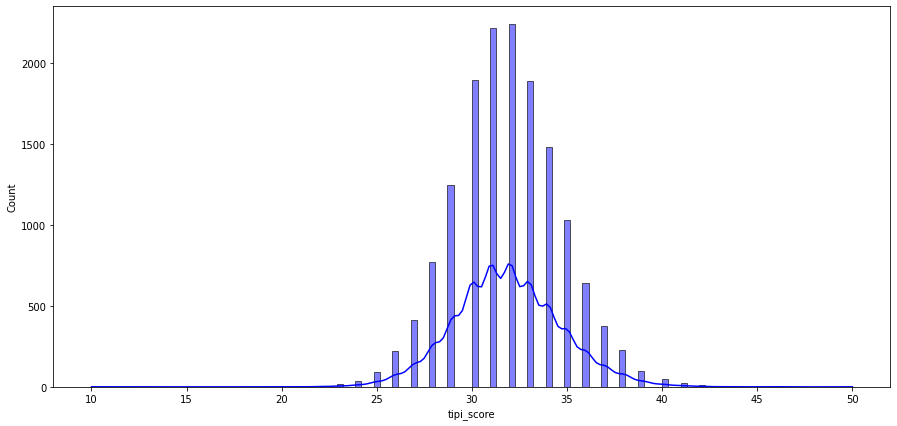

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(x = train['tipi_score'], kde=True, color='blue')

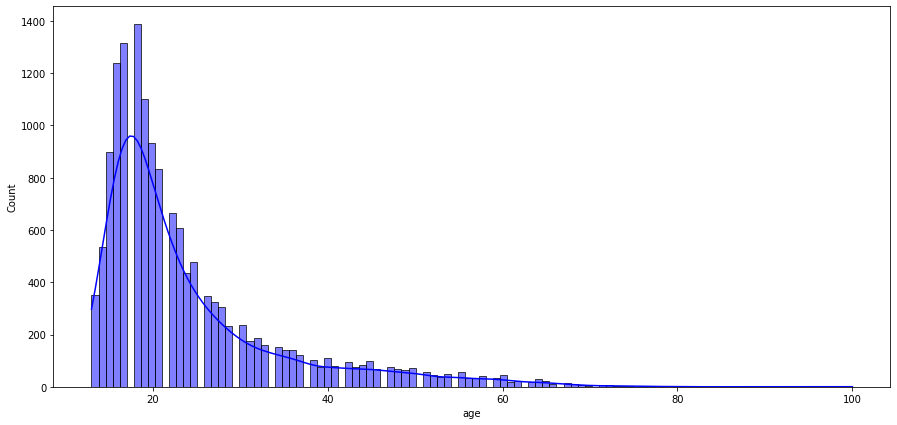

In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(x = train['age'], kde=True, color='blue')

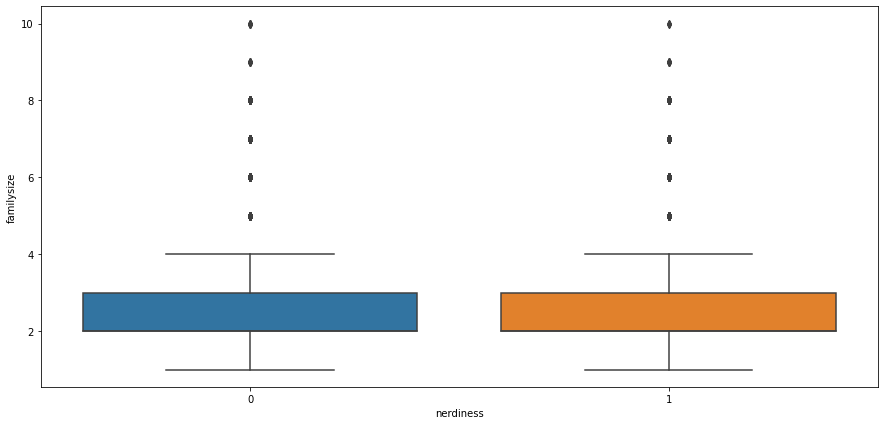

In [ ]:
plt.figure(figsize = (15,7))
sns.boxplot(x = train['nerdiness'], y= train['familysize'])

## Modeling


모델 학습 전 setup함수를 통해 실험 환경 구축

In [143]:
from pycaret.classification import *

clf = setup(data = train, target = 'nerdiness')

,Description,Value
0,session_id,675
1,Target,nerdiness
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(15000, 81)"
5,Missing Values,False
6,Numeric Features,61
7,Categorical Features,19
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='nerdiness',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_st...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluste

가장 좋은 성능의 모델 3가지 선택 ( Extra Tree, RandomForest, CatBoost

In [144]:
best_3 = compare_models(sort = "AUC", n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.77270,0.86200,0.83220,0.77330,0.80160,0.53650,0.53860,1.62800
rf,Random Forest Classifier,0.77050,0.85790,0.83430,0.76940,0.80050,0.53160,0.53410,1.58500
catboost,CatBoost Classifier,0.75400,0.82840,0.82040,0.75510,0.78630,0.49760,0.50010,8.63100
lightgbm,Light Gradient Boosting Machine,0.75240,0.82600,0.81420,0.75590,0.78390,0.49480,0.49690,0.46700
gbc,Gradient Boosting Classifier,0.73320,0.80690,0.80080,0.73820,0.76810,0.45530,0.45750,4.08300
ada,Ada Boost Classifier,0.72310,0.79440,0.79250,0.72960,0.75960,0.43450,0.43680,1.10900
lr,Logistic Regression,0.72590,0.79380,0.79140,0.73300,0.76110,0.44070,0.44260,2.78800
lda,Linear Discriminant Analysis,0.72540,0.79380,0.80350,0.72730,0.76350,0.43810,0.44130,0.44600
knn,K Neighbors Classifier,0.67720,0.72570,0.76000,0.68790,0.72210,0.33940,0.34200,1.50300
dt,Decision Tree Classifier,0.70260,0.69880,0.73580,0.72810,0.73180,0.39820,0.39840,0.22200


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 2
INFO:logs:[ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=675, verbose=0,
                     warm_start=False), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
  

In [145]:
blended = blend_models(estimator_list = best_3, fold = 5, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.77240,0.85100,0.83950,0.76920,0.80280,0.53490,0.53770
1,0.77000,0.85870,0.83090,0.77040,0.79950,0.53070,0.53280
2,0.77100,0.86420,0.83330,0.77020,0.80050,0.53260,0.53490
3,0.78240,0.86850,0.84110,0.78110,0.81000,0.55620,0.55830
4,0.75890,0.84670,0.82210,0.76040,0.79000,0.50810,0.51020
Mean,0.77090,0.85780,0.83340,0.77020,0.80060,0.53250,0.53480
Std,0.00750,0.00810,0.00680,0.00660,0.00640,0.01530,0.01530


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 3
INFO:logs:VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,

In [146]:
pred_holdout = predict_model(blended)

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                         

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.78650,0.86180,0.84670,0.78680,0.81570,0.56280,0.56500


전체 데이터셋에 대해서 학습

In [147]:
final_model = finalize_model(blended)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(bootstrap=False,
                                                   ccp_alpha=0.0,
                                                   class_weight=None,
                                                   criterion='gini',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                       

In [ ]:
predictions = predict_model(final_model, data = test)

In [174]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 79 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Q1               15000 non-null  float64
 1   Q2               15000 non-null  float64
 2   Q3               15000 non-null  float64
 3   Q4               15000 non-null  float64
 4   Q5               15000 non-null  float64
 5   Q6               15000 non-null  float64
 6   Q7               15000 non-null  float64
 7   Q8               15000 non-null  float64
 8   Q9               15000 non-null  float64
 9   Q10              15000 non-null  float64
 10  Q11              15000 non-null  float64
 11  Q12              15000 non-null  float64
 12  Q13              15000 non-null  float64
 13  Q14              15000 non-null  float64
 14  Q15              15000 non-null  float64
 15  Q16              15000 non-null  float64
 16  Q17              15000 non-null  float64
 17  Q18         

In [170]:
train.drop(['country', 'continent'], axis=1, inplace=True)
test.drop(['country', 'continent'], axis=1, inplace=True)

하이퍼파라미터 튜닝 Optuna


In [154]:
!pip install --quiet optuna

     |████████████████████████████████| 348 kB 4.8 MB/s 
     |████████████████████████████████| 81 kB 11.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 112 kB 64.0 MB/s 
     |████████████████████████████████| 49 kB 8.5 MB/s 
     |████████████████████████████████| 147 kB 66.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
pycaret 2.3.10 requires scipy<=1.5.4, but you have scipy 1.7.3 which is incompatible.
jax 0.3.17 requires numpy>=1.20, but you have numpy 1.19.5 which is incompatible.


In [156]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner

In [178]:
features = ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q7', 'Q8', 'Q9', 'Q10', 'Q11',
       'Q12', 'Q13', 'Q14', 'Q15', 'Q16', 'Q17', 'Q18', 'Q19', 'Q20', 'Q21',
       'Q22', 'Q23', 'Q24', 'Q25', 'Q26', 'TIPI1', 'TIPI2', 'TIPI3', 'TIPI4',
       'TIPI5', 'TIPI6', 'TIPI7', 'TIPI8', 'TIPI9', 'TIPI10', 'VCL1', 'VCL2',
       'VCL3', 'VCL4', 'VCL5', 'VCL6', 'VCL7', 'VCL8', 'VCL9', 'VCL10',
       'VCL11', 'VCL12', 'VCL13', 'VCL14', 'VCL15', 'VCL16', 'education',
       'urban', 'gender', 'engnat', 'age', 'hand', 'religion', 'orientation',
       'voted', 'married', 'familysize', 'ASD', 'country_encoded', 'AF', 'AS', 
       'EU', 'NA', 'NONE', 'OC', 'SA', 'total_time_min', 'tipi_score']
target =  ['nerdiness']

In [179]:
df_trains = []
df_valids = []

skf = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)
for train_index, valid_index in skf.split(train[features], train[target]):
    df_train = train.loc[train_index]
    df_valid = train.loc[valid_index]
    df_trains.append(df_train)
    df_valids.append(df_valid)

    x_train = df_train[features]
    y_train = df_train[target]

    x_test = df_valid[features]
    y_test = df_valid[target]

In [162]:
from sklearn.ensemble import ExtraTreesClassifier

In [181]:
def accuracy(true, pred):
    return np.mean(true==pred)

def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 20, step=1, log=False), 
        'n_estimators': trial.suggest_int('n_estimators', 1500, 3000, step=1, log=True), 
        'min_samples_split': trial.suggest_int("min_samples_split", 2, 5),
        'min_samples_leaf': trial.suggest_int("min_samples_leaf", 1, 5),
        'random_state': 21,
        'n_jobs': -1
    }
    
    score = []
    for df_train, df_valid in zip(df_trains, df_valids):
        clf = ExtraTreesClassifier(**params)
        clf.fit(x_train, y_train)
        
        pred = clf.predict_proba(df_valid[features])[:, 1]
        true = df_valid[target].values
        score.append(roc_auc_score(true, pred))
    score = np.mean(score)
    return score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=21), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=10)

[I 2022-09-13 14:15:26,348] A new study created in memory with name: no-name-5b02dab2-ca58-473e-beab-0b4f087bc4c0
[I 2022-09-13 14:18:10,670] Trial 0 finished with value: 0.9168010230131826 and parameters: {'max_depth': 10, 'n_estimators': 1832, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9168010230131826.
[I 2022-09-13 14:20:46,937] Trial 1 finished with value: 0.9484158085358683 and parameters: {'max_depth': 12, 'n_estimators': 1553, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9484158085358683.
[I 2022-09-13 14:24:46,418] Trial 2 finished with value: 0.9549203324272348 and parameters: {'max_depth': 13, 'n_estimators': 2248, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9549203324272348.
[I 2022-09-13 14:27:27,147] Trial 3 finished with value: 0.9198738024244942 and parameters: {'max_depth': 11, 'n_estimators': 1697, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 2 with v

In [182]:
optuna.visualization.plot_optimization_history(study)

In [183]:
optuna.visualization.plot_parallel_coordinate(study)

In [184]:
optuna.visualization.plot_param_importances(study)

In [ ]:
clfs = []
for df_train in df_trains:
    clf = ExtraTreesClassifier(**study.best_params)
    clf.fit(df_train[features], df_train[target])
    pred_clf = clf.predict_proba(x_test)[:, 1]
    print(roc_auc_score(y_test, pred_clf))
    clfs.append(clf)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [ ]:
clfs